# Importing the Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import re
import nltk
import sklearn
import catboost

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import plot_confusion_matrix

# Importing the dataset

In [2]:
index_col=["HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Summary", "Text"]
dataset = pd.read_csv("Reviews.csv", usecols=index_col)
dataset.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,3,3,5,Just like the original one in Saudi Arabia.,''''' '''' '' '''''''' ..<br />Just like the o...
1,0,0,5,Arrived Fast,-- - - - Item arrived in perfect condition and...
2,2,3,5,GUMBO! BEER! Are you ready for some football!,-- -- OK - Getcher beer! ---- Getcher Minute R...
3,0,0,5,Cat loves these!,- Been buying these for my cat for about a yea...
4,0,0,5,Pure bliss in a pod --,"-- better yet, 96 pods of caffeine bliss. Thi..."


In [3]:
dataset = dataset.iloc[:, :].query('HelpfulnessDenominator >0')

In [4]:
print(dataset)

        HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0                          3                       3      5   
2                          2                       3      5   
5                          1                       1      5   
6                          3                       3      5   
9                          4                       4      2   
...                      ...                     ...    ...   
256033                     4                       5      5   
256034                     8                       8      5   
256040                     1                       1      2   
256041                     2                       2      5   
256042                     1                       2      1   

                                                  Summary  \
0             Just like the original one in Saudi Arabia.   
2           GUMBO! BEER! Are you ready for some football!   
5                The best jerky I've ever tried! So good!   

In [5]:
X            = dataset.iloc[:,4:].values   #Taking out review text
votesHelpful = dataset.iloc[:,0].values  #Helpfulness for summary
votesTotal   = dataset.iloc[:,1].values

## Creating Helfulnesss index

In [6]:
print(len(votesHelpful))
y=[]

135906


In [7]:
for i in range(len(votesHelpful)):
    y.append(votesHelpful[i]/votesTotal[i])
    if(y[i]>=0.6):
        y[i] = 1
    else:
        y[i] = 0

In [8]:
print(len(y))

135906


In [9]:
print(X)

[["''''' '''' '' '''''''' ..<br />Just like the original one in Saudi Arabia.<br />Very recommended for Saudis who live in The United States."]
 ["-- -- OK - Getcher beer! ---- Getcher Minute Rice and Hotty-Sauce! ---- Nuke yer Campbell's Gumbo! ---- Put it all together!---- ------Open a cool one!---Enjoy the game! ----"]
 ["- Excellent cuts of meat with no tendons.<br />- Very tasty. Just the right mix of spices.<br />- No added MSG and no added sugar!<br />- Convenient small snack-size bags.<br /><br />The best jerky I've ever encountered."]
 ...
 ["Zuke's Mini Naturals Dog Treats Roasted Chicken Recipe, 16-Ounce, this product was turned down by my pet.  Gave it to another who had three dogs and only one of the dogs would eat it and the other two would not even take it out of the hand of owner.  I tried this product because it was a american product, would not recommend."]
 ['Zuma my Hairless Chinese Crested pup is a very finicky eater and would rather starve then eat something he do

# Cleaning the Dataset

### Listing Contractions

In [10]:
contractions={
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd've": "how did have",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "might have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "shall'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "will't've": "will not have",
    "would've": "would have",
    "would't": "would not",
    "would't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you have all",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

### Declaring Cleaning function:(contraction removal, html removed using regex, removed  stopwords by NLTK)

In [11]:
def clean_text(text, remove_stopwords = True):
    text = text.lower()
    if True:    # remove contractions
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', ' ', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, ' ', text)
    ps = PorterStemmer()
    if remove_stopwords:    # remove stopwords
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [ps.stem(word) for word in text if not word in set(stops)] #using Porter Stemmer
        text = " ".join(text)
    return text

### Applying clean_texts on individual line

In [12]:
for i in range(len(X)):
    for j in range(len(X[i])):
        X[i][j] = clean_text(X[i][j])
print(X)

[['like origin one saudi arabia recommend saudi live unit state']
 ['ok getcher beer getcher minut rice hotti sauc nuke yer campbel gumbo put togeth open cool one enjoy game']
 ['excel cut meat tendon tasti right mix spice ad msg ad sugar conveni small snack size bag best jerki ever encount']
 ...
 ['zuke mini natur dog treat roast chicken recip 16 ounc product turn pet gave anoth three dog one dog would eat two would even take hand owner tri product american product would recommend']
 ['zuma hairless chines crest pup finicki eater would rather starv eat someth like food eat cesar gourmet filet sauc ok find dog treat like husband brought home cesar grill chicken softi dog treat love treat look smell like dog treat thought way zuma would eat hundr dollar spent numer bog bakeri year half spent shop place found cesar grill chicken softi dog treat thrill reliev']
 ['zzzzzzz high hope coffe realli disappoint say better buy folger ad extra scoop filter buy use lot get strong cup coffe still 

In [13]:
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

## Making A Corpus

In [14]:
corpus = X.flatten()

In [15]:
print(X)

[['like origin one saudi arabia recommend saudi live unit state']
 ['ok getcher beer getcher minut rice hotti sauc nuke yer campbel gumbo put togeth open cool one enjoy game']
 ['excel cut meat tendon tasti right mix spice ad msg ad sugar conveni small snack size bag best jerki ever encount']
 ...
 ['zuke mini natur dog treat roast chicken recip 16 ounc product turn pet gave anoth three dog one dog would eat two would even take hand owner tri product american product would recommend']
 ['zuma hairless chines crest pup finicki eater would rather starv eat someth like food eat cesar gourmet filet sauc ok find dog treat like husband brought home cesar grill chicken softi dog treat love treat look smell like dog treat thought way zuma would eat hundr dollar spent numer bog bakeri year half spent shop place found cesar grill chicken softi dog treat thrill reliev']
 ['zzzzzzz high hope coffe realli disappoint say better buy folger ad extra scoop filter buy use lot get strong cup coffe still 

In [16]:
print(corpus)

['like origin one saudi arabia recommend saudi live unit state'
 'ok getcher beer getcher minut rice hotti sauc nuke yer campbel gumbo put togeth open cool one enjoy game'
 'excel cut meat tendon tasti right mix spice ad msg ad sugar conveni small snack size bag best jerki ever encount'
 ...
 'zuke mini natur dog treat roast chicken recip 16 ounc product turn pet gave anoth three dog one dog would eat two would even take hand owner tri product american product would recommend'
 'zuma hairless chines crest pup finicki eater would rather starv eat someth like food eat cesar gourmet filet sauc ok find dog treat like husband brought home cesar grill chicken softi dog treat love treat look smell like dog treat thought way zuma would eat hundr dollar spent numer bog bakeri year half spent shop place found cesar grill chicken softi dog treat thrill reliev'
 'zzzzzzz high hope coffe realli disappoint say better buy folger ad extra scoop filter buy use lot get strong cup coffe still went sleep 

In [17]:
len(corpus)

135906

## Tokenizing

In [48]:
tokenizer = Tokenizer(num_words = 4000, oov_token="<OOV>")

In [49]:
tokenizer.fit_on_texts(corpus)

In [50]:
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'like': 2, 'tast': 3, 'product': 4, 'use': 5, 'good': 6, 'one': 7, 'flavor': 8, 'tri': 9, 'love': 10, 'great': 11, 'would': 12, 'get': 13, 'tea': 14, 'coffe': 15, 'make': 16, 'food': 17, 'order': 18, 'buy': 19, 'time': 20, 'amazon': 21, 'realli': 22, 'eat': 23, 'price': 24, 'much': 25, 'find': 26, 'also': 27, 'store': 28, 'even': 29, 'best': 30, 'bag': 31, 'well': 32, 'box': 33, 'littl': 34, 'cup': 35, 'dog': 36, 'day': 37, 'drink': 38, 'go': 39, 'better': 40, 'year': 41, 'look': 42, '2': 43, 'first': 44, 'purchas': 45, 'water': 46, 'bought': 47, 'could': 48, 'packag': 49, 'mix': 50, 'want': 51, 'chocol': 52, 'found': 53, 'sugar': 54, 'recommend': 55, 'brand': 56, 'give': 57, 'work': 58, 'review': 59, 'made': 60, 'think': 61, 'way': 62, '1': 63, 'know': 64, 'say': 65, 'differ': 66, 'cannot': 67, 'ship': 68, '3': 69, 'two': 70, 'cat': 71, 'sweet': 72, 'thing': 73, 'sinc': 74, 'need': 75, 'free': 76, 'got': 77, 'pack': 78, 'still': 79, 'never': 80, 'enjoy': 81, 'mani': 82, '

## Inputs to text Sequences

In [51]:
input_sequences = []
input_sequences=tokenizer.texts_to_sequences(corpus)
#input_sequences = tokenizer.texts_to_matrix(corpus)
#for line in corpus:
#    token_list = tokenizer.texts_to_sequences([line])
#    for i in range(1, len(token_list)):
#        n_gram_sequence = token_list[:i+1]
#        input_sequences.append(n_gram_sequence)
# pad sequences 


In [52]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=100, padding='post'))

In [53]:
print(input_sequences)

[[   2  326    7 ...    0    0    0]
 [ 472    1 1063 ...    0    0    0]
 [ 176  379  353 ...    0    0    0]
 ...
 [   1 1204  138 ...    0    0    0]
 [   1    1 1227 ...    0    0    0]
 [   1  149  209 ...    0    0    0]]


In [54]:
print(len(y))

135906


In [55]:
print(len(input_sequences))

135906


# Splitting the Dataset into Train Set and Test Set


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_sequences, y, test_size = 0.2, random_state = 0)

# Trying different ML Models

## Decision Tree

### Training On Training Data

In [57]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

### Testing on Test Data

In [58]:
y_pred = classifier.predict(X_test)
y_test = np.array(y_test)
print(np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1))

[[1 0]
 [1 0]
 [1 1]
 ...
 [1 1]
 [0 1]
 [1 1]]


### Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 1612  4751]
 [ 4986 15833]]


0.6417850047825767

## XGBoost

### Training

In [60]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Testing

In [61]:
y_pred = classifier.predict(X_test)
y_test = np.array(y_test)
print(np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1))

[[1 1]
 [1 1]
 [1 1]
 ...
 [1 1]
 [0 1]
 [1 1]]


### Confusion Matrix

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[   69  6294]
 [  138 20681]]


0.763372820248694

## CatBoost

### Training

In [63]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier()
classifier.fit(X_train, y_train)

Learning rate set to 0.076286
0:	learn: 0.6686111	total: 45.1ms	remaining: 45.1s
1:	learn: 0.6480449	total: 89.3ms	remaining: 44.6s
2:	learn: 0.6306840	total: 124ms	remaining: 41.1s
3:	learn: 0.6161595	total: 161ms	remaining: 40s
4:	learn: 0.6037977	total: 195ms	remaining: 38.8s
5:	learn: 0.5933154	total: 233ms	remaining: 38.6s
6:	learn: 0.5844630	total: 261ms	remaining: 37s
7:	learn: 0.5770329	total: 289ms	remaining: 35.8s
8:	learn: 0.5706504	total: 318ms	remaining: 35s
9:	learn: 0.5653954	total: 346ms	remaining: 34.3s
10:	learn: 0.5608146	total: 386ms	remaining: 34.7s
11:	learn: 0.5568351	total: 415ms	remaining: 34.2s
12:	learn: 0.5535825	total: 447ms	remaining: 34s
13:	learn: 0.5507583	total: 499ms	remaining: 35.2s
14:	learn: 0.5483569	total: 538ms	remaining: 35.3s
15:	learn: 0.5462474	total: 588ms	remaining: 36.2s
16:	learn: 0.5445224	total: 619ms	remaining: 35.8s
17:	learn: 0.5429801	total: 657ms	remaining: 35.8s
18:	learn: 0.5416810	total: 687ms	remaining: 35.5s
19:	learn: 0.5405

### Testing

In [64]:
y_pred = classifier.predict(X_test)
y_test = np.array(y_test)
print(np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1))

[[1 1]
 [1 1]
 [1 1]
 ...
 [1 1]
 [0 1]
 [1 1]]


### Confusion Matrix

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[   10  6353]
 [    9 20810]]


0.7659480538591715

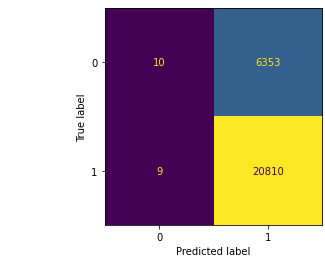

In [66]:
plot_confusion_matrix(classifier, X_test, y_test)  

In [67]:
new_review = '4 and flavor are misleading. They all tasted exactly the same: like nothing. The only difference was the scents they each gave off, which were surprisingly pleasant. Its too bad the flavor didnt follow suit.'
new_review = clean_text(new_review)
new_corpus = [new_review]
new_X_test = tokenizer.texts_to_sequences(new_corpus)
prediction_sequence = np.array(pad_sequences(new_X_test, maxlen=200, padding='post'))
new_y_pred = classifier.predict(prediction_sequence)
print(new_y_pred)

[1]


In [68]:
print(new_X_test)

[[102, 8, 1354, 3, 434, 2, 232, 66, 1112, 288, 1727, 919, 117, 8, 1589, 500, 2205]]


In [69]:
print(new_review)

4 flavor mislead tast exactli like noth differ scent gave surprisingli pleasant bad flavor didnt follow suit
